# Geodesic Example

First, we import the necessary modules.

In [1]:
%load_ext autoreload
%autoreload 2

from fadge.metric import KerrSchild
from fadge.geode  import Geode
from fadge.utils  import Nullify

from jax          import numpy  as np
from matplotlib   import pyplot as plt

Here are the parameters that specify the example

In [2]:
aspin = 0.9375
nray  = 256
fhlim = 0.75
eps   = 1e-2
tol   = 1e-3

Find the outer horizon and create the `metric`, `nullify`, `hlim`, and `run` functions

In [3]:
metric  = KerrSchild(aspin)
nullify = Nullify(metric)

aa = aspin * aspin
if aspin < 1:
    reh = 1.0 + np.sqrt(1 - aa)
    print('Radius of outer event horizon:', reh)
else:
    reh = 0
    print('There is no event horizon')

def KSr(x): # closure on aa
    zz = x[3] * x[3]
    kk = 0.5 * (x[1] * x[1] + x[2] * x[2] + zz - aa)
    rr = np.sqrt(kk * kk + aa * zz) + kk
    return np.sqrt(rr)

def hlim(l, s): # closure on fhlim
    return KSr(s[0]) * fhlim + 1

def run(l, s): # closure on reh
    return KSr(s[0]) >= reh + eps

Radius of outer event horizon: 1.3479853


and the initial condition of null geodesics...

In [4]:
s = []
for i in range(-nray//2,nray//2):
    x =            np.array([0,10000,-16*i/nray,4.9])
    v = nullify(x, np.array([1,    1,  0,       0  ]))
    s.append(np.array([x, v]))
s = np.array(s).transpose((1,2,0))

print(s.shape)

(2, 4, 256)


Create the geode object, which will store the states of the integration.

In [5]:
geode = Geode(
    metric, 0, s, L=-20000, hlim=hlim, filter=run, 
    atol=tol, rtol=tol, names={'ind':'lambda'})

/Users/ckc/Library/Python/3.9/lib/python/site-packages/jax/experimental/maps.py:517: UserWarning: xmap is an experimental feature and probably has bugs!
  warn("xmap is an experimental feature and probably has bugs!")
0it [00:00, ?it/s]

jit(masked_do); input: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[2,4,256])>with<DynamicJaxprTrace(level=0/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> [Traced<ShapedArray(float32[2,4,256])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,256])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,256])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,256])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,256])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,256])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[2,4,256])>with<DynamicJaxprTrace(level=0/1)>]


921it [00:11, 77.03it/s, lambda=-2.58e+04, dlambda=-1.66e+04] 


Interpolate data points near the black hole and also obtain the full step points.

In [6]:
l = np.linspace(-10100,-9900,2001)
i = geode(l) # interpolate

f = geode.states # full steps
print(f.shape)

ix = i[:,0,1,:]
iy = i[:,0,2,:]
iz = i[:,0,3,:]

fx = f[:,0,1,:]
fy = f[:,0,2,:]
fz = f[:,0,3,:]

(922, 2, 4, 256)


Here's the result from the full domain.
Thanks to adaptive time stepping, the step size far away from the black hole are always very large.

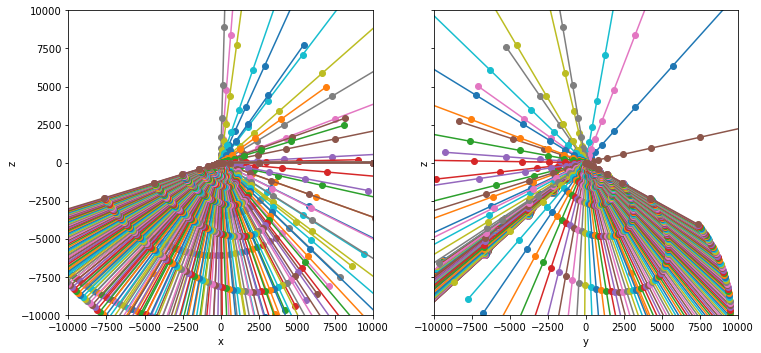

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12), sharey=True)

for j in range(nray):
    ax1.plot(fx[:,j], fz[:,j], '-o', color=f'C{j}')
    ax2.plot(fy[:,j], fz[:,j], '-o', color=f'C{j}')
    
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax1.set_xlim(-10000,10000)
ax1.set_ylim(-10000,10000)
ax1.set_aspect('equal')

ax2.set_xlabel('y')
ax2.set_ylabel('z')
ax2.set_xlim(-10000,10000)
ax2.set_ylim(-10000,10000)
ax2.set_aspect('equal')

Zoomed-in

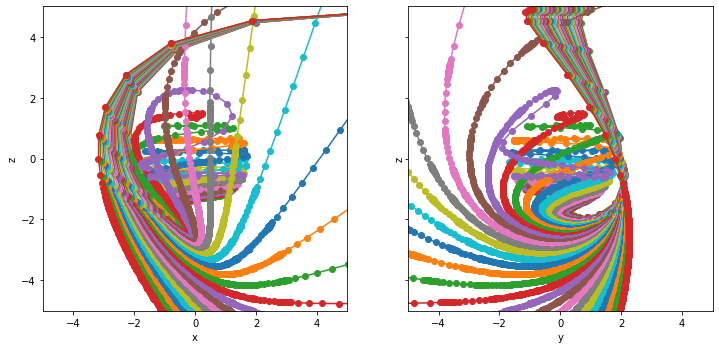

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12), sharey=True)

for j in range(7*nray//16,9*nray//16):
    ax1.plot(fx[:,j], fz[:,j], '-o', color=f'C{j}')
    ax2.plot(fy[:,j], fz[:,j], '-o', color=f'C{j}')
    
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_aspect('equal')

ax2.set_xlabel('y')
ax2.set_ylabel('z')
ax2.set_xlim(-5,5)
ax2.set_ylim(-5,5)
ax2.set_aspect('equal')

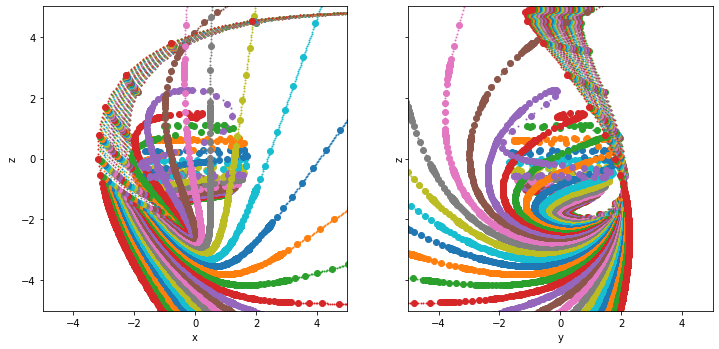

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12), sharey=True)

for j in range(7*nray//16,9*nray//16):
    ax1.scatter(fx[:,j], fz[:,j],      color=f'C{j}')
    ax1.scatter(ix[:,j], iz[:,j], s=1, color=f'C{j}')
    ax2.scatter(fy[:,j], fz[:,j],      color=f'C{j}')
    ax2.scatter(iy[:,j], iz[:,j], s=1, color=f'C{j}')
    
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_aspect('equal')

ax2.set_xlabel('y')
ax2.set_ylabel('z')
ax2.set_xlim(-5,5)
ax2.set_ylim(-5,5)
ax2.set_aspect('equal')

Note that some geodesics stay near the event horizon.
This can be more easily seen by combining the full steps and the interpolating points, and overplot the event horizon.

In [10]:
t   = np.linspace(-np.pi, np.pi, num=91)
Reh = np.sqrt(reh*reh + aa) * np.sin(t)
zeh =         reh           * np.cos(t)

In [11]:
fb = 907 # TODO: automaticall determine these values
ib = 920 # TODO: automaticall determine these values

x = np.concatenate([fx[:fb,:], ix[ib:,:]])
y = np.concatenate([fy[:fb,:], iy[ib:,:]])
z = np.concatenate([fz[:fb,:], iz[ib:,:]])

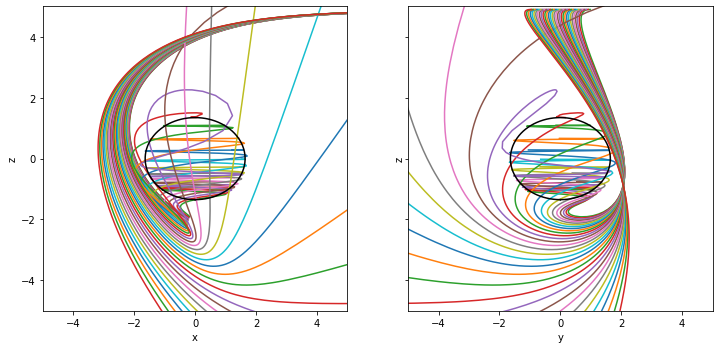

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,12), sharey=True)

for j in range(7*nray//16,9*nray//16):
    ax1.plot(x[:,j], z[:,j], color=f'C{j}')
    ax2.plot(y[:,j], z[:,j], color=f'C{j}')
    
ax1.plot(Reh, zeh, 'k')
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax1.set_xlim(-5,5)
ax1.set_ylim(-5,5)
ax1.set_aspect('equal')

ax2.plot(Reh, zeh, 'k')
ax2.set_xlabel('y')
ax2.set_ylabel('z')
ax2.set_xlim(-5,5)
ax2.set_ylim(-5,5)
ax2.set_aspect('equal')